<a href="https://colab.research.google.com/github/JuanM-GG/Biologia-de-sistemas/blob/main/sensibilidad_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Análisis de sensibilidad con R 

Nombre: Biología de sistemas

Fecha: 9 de diciembre del 2020

instalar librerías 

In [27]:
install.packages("deSolve")
install.packages("FME")
install.packages("rootSolve")
install.packages("sensitivity")
install.packages("checkmate")
install.packages("ODEnetwork")
install.packages("ODEsensitivity")
install.packages("vioplot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [28]:
library(deSolve)
library(sensitivity)
library(checkmate)
library(ODEnetwork)
library(ODEsensitivity)
library(vioplot)

Modelo de Lotka-Volterra

In [29]:
##### Lotka-Volterra equations #####
# The model function:
LVmod <- function(Time, State, Pars) {
  with(as.list(c(State, Pars)), {
    Ingestion    <- rIng  * Prey * Predator
    GrowthPrey   <- rGrow * Prey * (1 - Prey/K)
    MortPredator <- rMort * Predator
    
    dPrey        <- GrowthPrey - Ingestion
    dPredator    <- Ingestion * assEff - MortPredator
    
    return(list(c(dPrey, dPredator)))
  })
}

Existen cinco parámetros en el modelo: 


1.   r, tasa de crecimiento de la presa (1/tiempo)
2.   K, capacidad de carga de la presa (presa)
3.   c, tasa de consumo de presas por el depredador (1/tiempo*depredador)
4.   a, coeficiente que mide la asimilación del consumo por parte del depredador (depredador/presa)
5.   delta, tasa de muerte del depredador

Estos cinco parámetros son considerados como las variables de entrada en el análisis de sensibilidad. Por lo tanto, analizaremos la sensibilidad de las poblaciones de presa y depredador con respecto a cambios en estos cinco parámetros


Los parámetros a ser considerados en el análisis de sensibilidad y sus límites inferior y superior son: 

In [30]:
LVpars  <- c("rIng", "rGrow", "rMort", "assEff", "K")
LVbinf <- c(0.05, 0.05, 0.05, 0.05, 1)
LVbsup <- c(1.00, 3.00, 0.95, 0.95, 20)

Condiciones iniciales

In [31]:
# The initial values of the state variables:
LVinit  <- c(Prey = 1, Predator = 2)
# The timepoints of interest:

Intervalo de tiempo de interés

In [32]:
LVtimes <- c(0.01, seq(1, 5, by = 0.1))

Análisis Sobol (aquí solo con n = 500, pero se recomienda n = 1000)

Cuidado: El siguiente código podría tomar mucho tiempo en ejecutarse

In [33]:
set.seed(59281)
# Sobol' sensitivity analysis (here only with n = 500, but n = 1000 is
# recommended):
# Warning: The following code might take very long!

LVres_sobol <- ODEsobol(mod = LVmod,
                        pars = LVpars,
                        state_init = LVinit,
                        times = LVtimes,
                        n = 500,
                        rfuncs = "runif",
                        rargs = paste0("min = ", LVbinf,
                                       ", max = ", LVbsup),
                        sobol_method = "Martinez",
                        ode_method = "lsoda",
                        parallel_eval = TRUE,
                        parallel_eval_ncores = 2)

Es una lista de la clase *ODEmorris* con un elemento por cada variable de estado (aquí, P y N). Esos elementos son matrices de *3 length(LVpars) + 1* renglones y *length(LVtimes)* columnas. El primer renglon contiene una copia de todos de todos los valores de tiempo. Los otros renglones contienen los 3 índices de sensibilidad Sobol para todos los parámetros en todos los 51 valores de tiempo. 

In [34]:
str(LVres_sobol, vec.len = 3, give.attr = FALSE)

List of 2
 $ Prey    :List of 2
  ..$ S: num [1:6, 1:42] 0.01 0.242 0.557 0 ...
  ..$ T: num [1:6, 1:42] 1.00e-02 3.10e-01 5.81e-01 2.30e-06 ...
 $ Predator:List of 2
  ..$ S: num [1:6, 1:42] 0.01 0.1852 0.0166 0.636 ...
  ..$ T: num [1:6, 1:42] 1.00e-02 2.07e-01 1.35e-05 6.31e-01 ...


Graficar resultados 

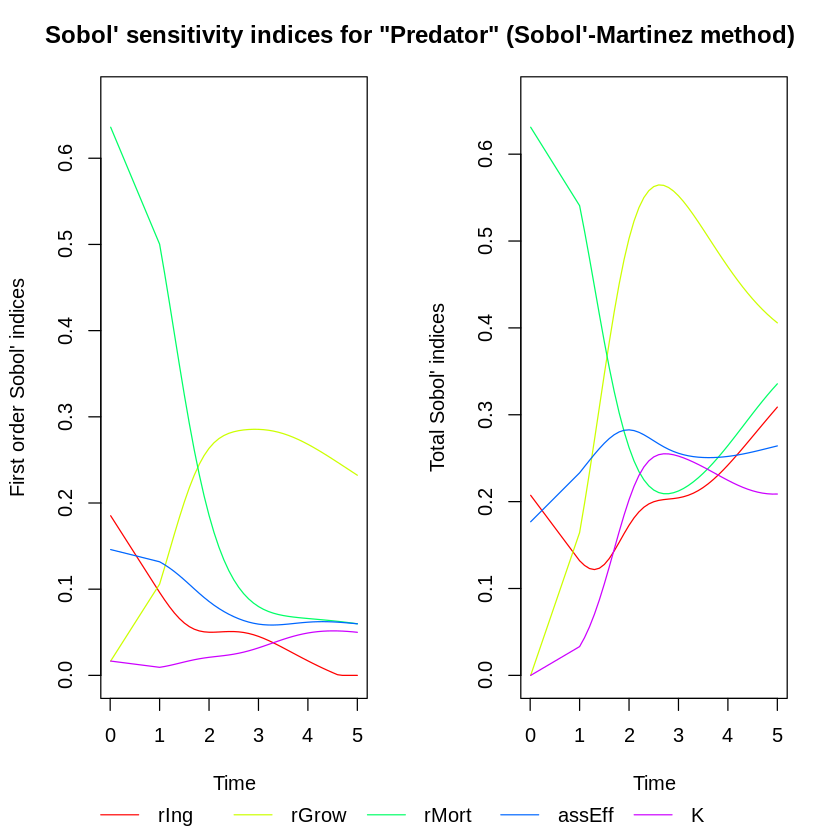

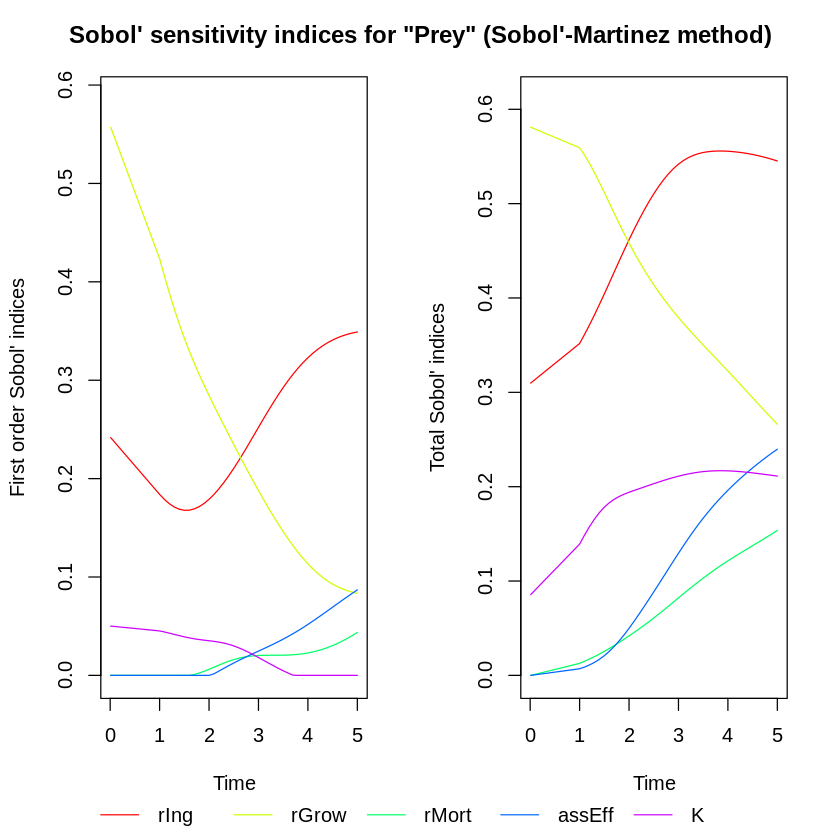

In [35]:
plot(LVres_sobol,  state_plot = "Predator")

plot(LVres_sobol,  state_plot = "Prey")

Ahora vamos a graficar la distribución de los indices por tiempo 

In [36]:
x1 <- LVres_sobol$Prey$S[2, ]
x2 <- LVres_sobol$Prey$S[3, ]
x3 <- LVres_sobol$Prey$S[4, ]
x4 <- LVres_sobol$Prey$S[5, ]
x5 <- LVres_sobol$Prey$S[6, ]

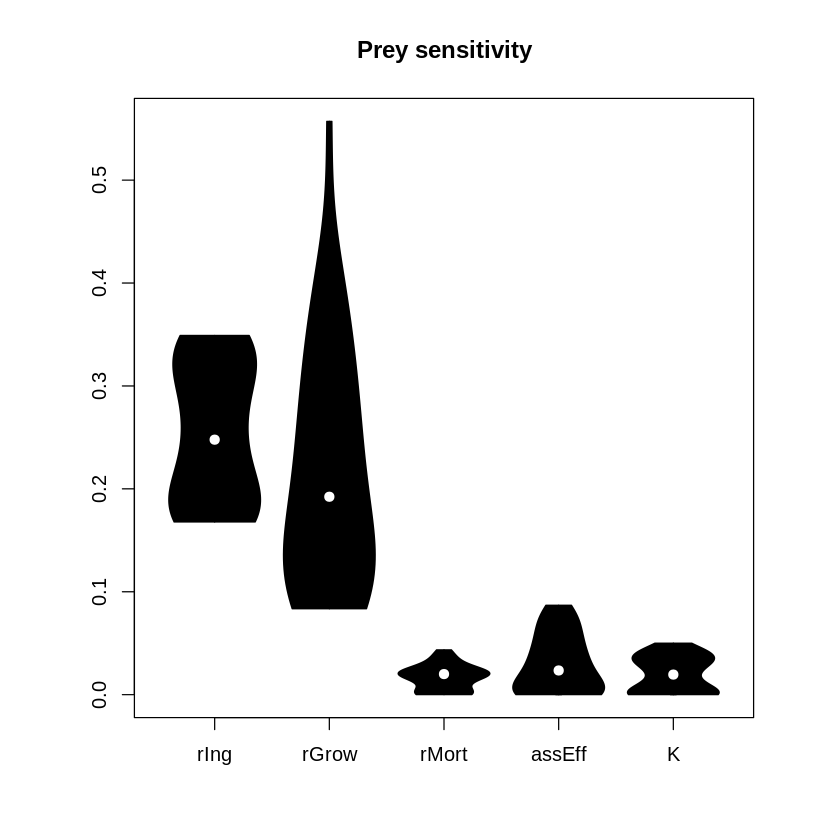

In [37]:
par(pty = "s")
vioplot(x1,x2,x3,x4,x5, names = LVpars, col = "black")
title("Prey sensitivity")

In [38]:

y1 <- LVres_sobol$N$S[2, ]
y2 <- LVres_sobol$N$S[3, ]
y3 <- LVres_sobol$N$S[4, ]
y4 <- LVres_sobol$N$S[5, ]
y5 <- LVres_sobol$N$S[6, ]

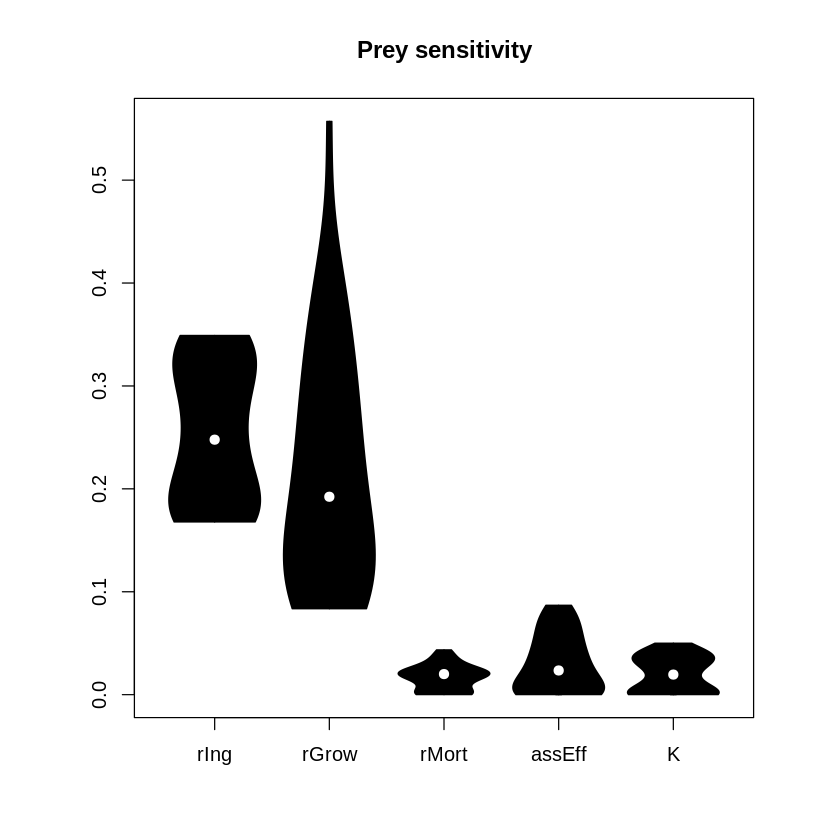

In [39]:
par(pty="s") 
vioplot(x1, x2, x3,x4, x5, names=LVpars,  col="black")
title("Prey sensitivity")

In [40]:
y1 <- LVres_sobol$Predator$S[2, ]
y2 <- LVres_sobol$Predator$S[3, ]
y3 <- LVres_sobol$Predator$S[4, ]
y4 <- LVres_sobol$Predator$S[5, ]
y5 <- LVres_sobol$Predator$S[6, ]

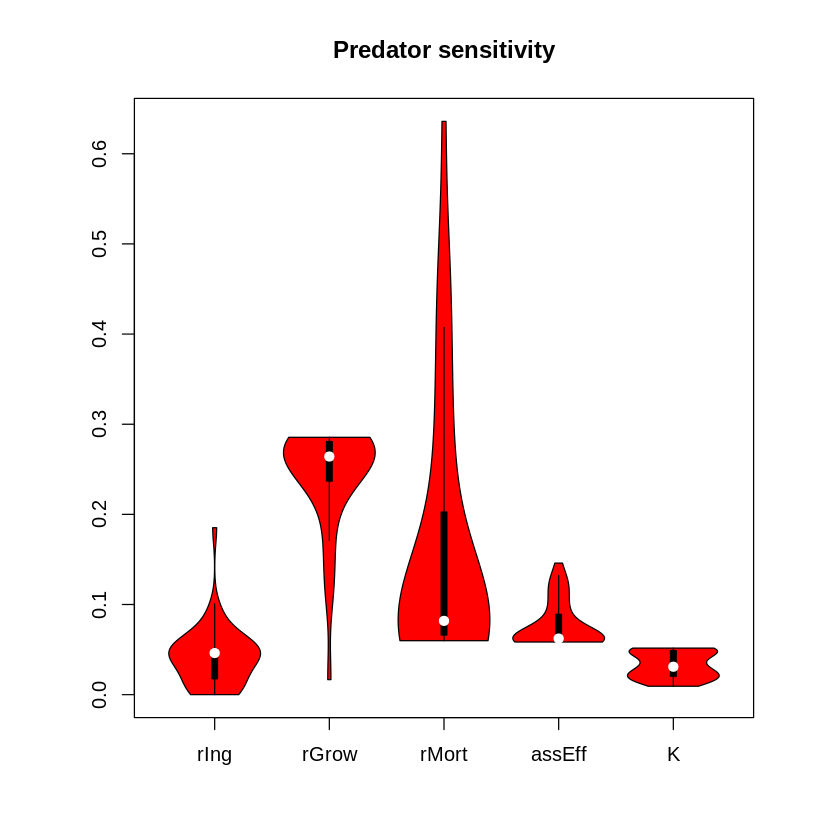

In [41]:
par(pty="s") 
vioplot(y1, y2, y3,y4, y5, names=LVpars,  col="red")
title("Predator sensitivity")